# Farfetch case study

## Product category classification
- Author: Kai Chen
- Date: Apr, 2018


In [84]:
import sys

import pandas as pd
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from scipy.sparse import csr_matrix, hstack

from nltk.corpus import stopwords

from keras.preprocessing.text import text_to_word_sequence

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

np.random.seed(42)

In [85]:
# ---------------------
# Define the file paths
PRODUCT_CSV_FILE = 'data/products.csv'
ATTRIBUTE_CSV_FILE = 'data/attributes.csv'

attribute_name_col_name = 'AttributeName'
attribute_value_col_name = 'AttributeValueName'
attribute_col_name = 'Attribute'
product_id_col_name = 'ProductId'
product_description_col_name = 'Description'

## Step 1: read and explore the data

In [86]:
df_product = pd.read_csv(PRODUCT_CSV_FILE)
#display(df_product.describe())
display(df_product.head())
print(df_product.shape)


,ProductId,Description,DescriptionDate,SeasonOriginal,ProductName,Brand,Gender,Colour,Family,Category,ArticlePhotoId,CreateDate
0,11295277,VIPE6CE-169953MCC 38NO,2016-01-07 13:13:09.527,SS15,Celine Black Phantom Bag,CELINE COLLARD,WOMEN,BLACK,Bags,Tote Bags,6129459,2016-01-07 13:10:46.507
1,11292059,Grey cotton 'Skip' crewneck from S.N.S. Herni...,2016-01-08 14:45:59.673,SS16,'Skip' crewneck,S.N.S. HERNING,MEN,GREY,Clothing,Sweaters & Knitwear,6156126,2016-01-04 19:52:05.203
2,11290981,Multicolour cotton 'Pak’r Tatenda' backpack fr...,2016-01-11 19:27:45.330,SS16,'Pakr Tatenda' backpack,EASTPAK,UNISEX,YELLOW & ORANGE,Bags,Backpacks,6216609,2016-01-03 15:21:20.480
3,11293179,Ivory white and black hemp-cotton blend 'Honey...,2016-01-13 11:33:11.150,SS16,'Honey' wide brim hat,EUGENIA KIM,WOMEN,WHITE,Accessories,Hats,6199465,2016-01-05 18:08:57.317
4,11293099,Ivory white cotton embroidered lace frilled dr...,2016-01-13 15:22:08.247,SS16,embroidered lace frilled dress,RED VALENTINO,WOMEN,WHITE,Clothing,Dresses,6173011,2016-01-05 16:55:35.427


(12631, 12)


In [87]:
df_attribute = pd.read_csv(ATTRIBUTE_CSV_FILE)
df_attribute[attribute_col_name] = df_attribute[attribute_name_col_name] + '-'+ df_attribute[attribute_value_col_name]

display(df_attribute.head())
print(df_attribute.shape)

,ProductId,AttributeName,AttributeValueName,Attribute
0,11290663,Sleeve Length,3/4 Sleeves,Sleeve Length-3/4 Sleeves
1,11290693,Knit Neckline,Crew Neck,Knit Neckline-Crew Neck
2,11290726,Detail,Stiletto,Detail-Stiletto
3,11290726,Heel Height,High Heel,Heel Height-High Heel
4,11290743,Knit Neckline,Crew Neck,Knit Neckline-Crew Neck


(13455, 4)


In [88]:
df_product_attribute = pd.merge(df_product, df_attribute, on=[product_id_col_name])

display(df_product_attribute.head(5))
print(df_product_attribute.shape)

,ProductId,Description,DescriptionDate,SeasonOriginal,ProductName,Brand,Gender,Colour,Family,Category,ArticlePhotoId,CreateDate,AttributeName,AttributeValueName,Attribute
0,11292059,Grey cotton 'Skip' crewneck from S.N.S. Herni...,2016-01-08 14:45:59.673,SS16,'Skip' crewneck,S.N.S. HERNING,MEN,GREY,Clothing,Sweaters & Knitwear,6156126,2016-01-04 19:52:05.203,Knit Neckline,Crew Neck,Knit Neckline-Crew Neck
1,11293099,Ivory white cotton embroidered lace frilled dr...,2016-01-13 15:22:08.247,SS16,embroidered lace frilled dress,RED VALENTINO,WOMEN,WHITE,Clothing,Dresses,6173011,2016-01-05 16:55:35.427,Dress Length,Short,Dress Length-Short
2,11293099,Ivory white cotton embroidered lace frilled dr...,2016-01-13 15:22:08.247,SS16,embroidered lace frilled dress,RED VALENTINO,WOMEN,WHITE,Clothing,Dresses,6173011,2016-01-05 16:55:35.427,Dress Silhouette,Fitted,Dress Silhouette-Fitted
3,11293099,Ivory white cotton embroidered lace frilled dr...,2016-01-13 15:22:08.247,SS16,embroidered lace frilled dress,RED VALENTINO,WOMEN,WHITE,Clothing,Dresses,6173011,2016-01-05 16:55:35.427,Neckline,Round Neck,Neckline-Round Neck
4,11293099,Ivory white cotton embroidered lace frilled dr...,2016-01-13 15:22:08.247,SS16,embroidered lace frilled dress,RED VALENTINO,WOMEN,WHITE,Clothing,Dresses,6173011,2016-01-05 16:55:35.427,Sleeve Length,Sleeveless,Sleeve Length-Sleeveless


(13455, 15)


In [89]:
print('number of attributes: {}'.format(len(df_product_attribute[attribute_col_name].unique())))

number of attributes: 112


In [90]:
display(df_product_attribute[attribute_col_name].unique()[0:10])

array(['Knit Neckline-Crew Neck', 'Dress Length-Short',
       'Dress Silhouette-Fitted', 'Neckline-Round Neck',
       'Sleeve Length-Sleeveless', 'Leg Length-Regular',
       'Detail-Stiletto', 'Heel Height-High Heel',
       'Sleeve Length-Shortsleeved', 'Sleeve Length-Longsleeved'],
      dtype=object)

In [91]:
list_product_id = df_attribute[product_id_col_name].unique()
print('number of products: {}'.format(len(list_product_id)))

number of products: 7362


In [92]:
# Create a dictionary, key: product id -> value: description
dict_product_des = dict()
for product_id in list_product_id:
    # We assume that one product has only one description.
    if product_id in dict_product_des:
        print('product {} has more than one description'.format(product_id))
    df_sub = df_product_attribute[df_product_attribute[product_id_col_name] == product_id]
    dict_product_des[product_id] = df_sub[product_description_col_name].values[0]

for product_id in list_product_id[0:5]:
    print(product_id)
    print(dict_product_des[product_id])

11290663
Black boxy long line sweatshirt from Neil Barrett featuring a crew neck, shoulder pads, three-quarter length sleeves, a two tone design and a straight hem. 
11290693
Blue cotton striped jumper  from Dolce & Gabbana featuring a ribbed crew neck, horizontal stripes, long sleeves and a ribbed hem and cuffs. 
11290726
Black silk and leather flower sandals from Charlotte Olympia featuring a peep toe, an ankle strap, a high stiletto heel and a branded insole. 
11290743
Black cotton zip neck sweatshirt  from Saint Laurent featuring a crew neck, long sleeves, a ribbed hem and cuffs and a silver-tone zip detail around the neck. 
11290777
Indio blue cotton slim fit jeans   from Simon Miller. 


In [93]:
# Create a dictionary, key: attributes -> value: product id list
list_attribute = df_product_attribute[attribute_col_name].unique()
dict_attribute = dict()
dict_attribute_nb_products = dict()
for attribute in list_attribute:
    if attribute not in dict_attribute:
        dict_attribute[attribute] = []
    dict_attribute[attribute].append(df_product_attribute[df_product_attribute[attribute_col_name] == attribute][product_id_col_name].values)

nb_products_attribute = []
for attribute in list_attribute:
    dict_attribute_nb_products[attribute] = len(dict_attribute[attribute][0])
    nb_products_attribute.append(len(dict_attribute[attribute][0]))
    
#for attribute in list_attribute[0:5]:
#    print(attribute)
#    display(dict_attribute[attribute])
    
for attribute in list_attribute[0:5]:
    print(attribute)
    print('number of products: {}'.format(dict_attribute_nb_products[attribute]))
    

Knit Neckline-Crew Neck
number of products: 346
Dress Length-Short
number of products: 396
Dress Silhouette-Fitted
number of products: 176
Neckline-Round Neck
number of products: 973
Sleeve Length-Sleeveless
number of products: 632


plot number of products per attribute


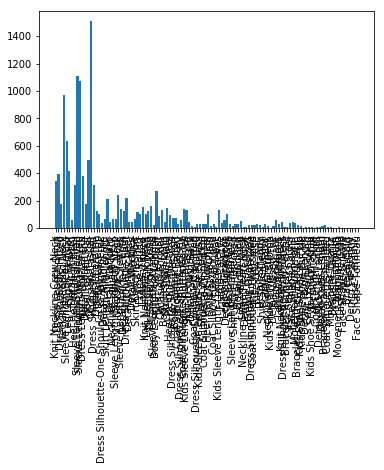

In [94]:
# Show number of products per attribute
print('plot number of products per attribute')
plt.bar(range(len(dict_attribute_nb_products)), list(dict_attribute_nb_products.values()), align='center')
plt.xticks(range(len(dict_attribute_nb_products)), list(dict_attribute_nb_products.keys()))
plt.xticks(rotation=90)
# # for python 2.x:
# plt.bar(range(len(dict_attribute_nb_products)), dict_attribute_nb_products.values(), align='center')  # python 2.x
# plt.xticks(range(len(dict_attribute_nb_products)), dict_attribute_nb_products.keys())  # in python 2.x
plt.show()

In [95]:
# Get max and min number of products per attribute
min_products = sys.maxsize
min_products_attribute = ''
max_products = 0
max_products_attribute = ''
for category, nb_products in dict_attribute_nb_products.items():
    if nb_products < min_products:
        min_products = nb_products
        min_products_attribute = category
    if nb_products > max_products:
        max_products = nb_products
        max_products_attribute = category

print('attribute {} has the max number of products, i.e., {}'.format(max_products_attribute, max_products))
print('attribute {} has the min number of products, i.e., {}'.format(min_products_attribute, min_products))
print('mean number of products per attribute: {}'.format(round(np.mean(nb_products_attribute), 2)))
print('standard deviation of number of products per attribute: {}'.format(round(np.std(nb_products_attribute), 2)))


attribute Occasion-Casual has the max number of products, i.e., 1512
attribute Case-White Gold has the min number of products, i.e., 1
mean number of products per attribute: 120.13
standard deviation of number of products per attribute: 233.28


In [96]:
# Create a dictionary, key: product id -> value: one-hot encoding list of attributes
list_attribute_value = df_attribute[attribute_col_name].unique()
dict_product_att = dict()

for product_id in list_product_id:
    # one-hot encoding list of attribute value name
    dict_product_att[product_id] = dict()
    for attribute in list_attribute_value:
        dict_product_att[product_id][attribute] = 0
    list_product_attribute = df_product_attribute[df_product_attribute[product_id_col_name] == product_id][attribute_col_name]
    for attribute in list_product_attribute:
        dict_product_att[product_id][attribute] = 1
        
#display(dict_product_att)
#for key, value in dict_product_att.items():
#    print(key)
#    print(value)

for product_id in list_product_id[0:3]:
    print(product_id)
    display(dict_product_att[product_id])

11290663


{'Body Length-Long': 0,
 'Body Length-Mid-Length': 0,
 'Body Length-Short': 0,
 'Bracelet-Gold': 0,
 'Bracelet-Leather/Exotic Skin': 0,
 'Bracelet-Rubber/ Plastic': 0,
 'Bracelet-Stainless Steel': 0,
 'Bracelet-Textile': 0,
 'Case-Ceramic': 0,
 'Case-Gold': 0,
 'Case-Stainless Steel': 0,
 'Case-Titanium': 0,
 'Case-White Gold': 0,
 'Coat Length-Long': 0,
 'Coat Length-Short': 0,
 'Coat Silhouette-Belted': 0,
 'Coat Silhouette-Buttoned Up': 0,
 'Coat Silhouette-Fitted': 0,
 'Coat Silhouette-Hooded': 0,
 'Coat Silhouette-Oversized': 0,
 'Coat Silhouette-Padded': 0,
 'Coat Silhouette-Zipped Up': 0,
 'Denim Fit-Regular': 0,
 'Denim Fit-Skinny': 0,
 'Denim Fit-Slim': 0,
 'Detail-Almond toe': 0,
 'Detail-Ankle Length': 0,
 'Detail-Buckled': 0,
 'Detail-Chunky heel': 0,
 'Detail-Closed Toe': 0,
 'Detail-Knee Length': 0,
 'Detail-Lace Up': 0,
 'Detail-Mid-Calf Length': 0,
 'Detail-Open Toe': 0,
 'Detail-Platform': 0,
 'Detail-Pointed toe': 0,
 'Detail-Round toe': 0,
 'Detail-Sling Back': 0,
 '

11290693


{'Body Length-Long': 0,
 'Body Length-Mid-Length': 0,
 'Body Length-Short': 0,
 'Bracelet-Gold': 0,
 'Bracelet-Leather/Exotic Skin': 0,
 'Bracelet-Rubber/ Plastic': 0,
 'Bracelet-Stainless Steel': 0,
 'Bracelet-Textile': 0,
 'Case-Ceramic': 0,
 'Case-Gold': 0,
 'Case-Stainless Steel': 0,
 'Case-Titanium': 0,
 'Case-White Gold': 0,
 'Coat Length-Long': 0,
 'Coat Length-Short': 0,
 'Coat Silhouette-Belted': 0,
 'Coat Silhouette-Buttoned Up': 0,
 'Coat Silhouette-Fitted': 0,
 'Coat Silhouette-Hooded': 0,
 'Coat Silhouette-Oversized': 0,
 'Coat Silhouette-Padded': 0,
 'Coat Silhouette-Zipped Up': 0,
 'Denim Fit-Regular': 0,
 'Denim Fit-Skinny': 0,
 'Denim Fit-Slim': 0,
 'Detail-Almond toe': 0,
 'Detail-Ankle Length': 0,
 'Detail-Buckled': 0,
 'Detail-Chunky heel': 0,
 'Detail-Closed Toe': 0,
 'Detail-Knee Length': 0,
 'Detail-Lace Up': 0,
 'Detail-Mid-Calf Length': 0,
 'Detail-Open Toe': 0,
 'Detail-Platform': 0,
 'Detail-Pointed toe': 0,
 'Detail-Round toe': 0,
 'Detail-Sling Back': 0,
 '

11290726


{'Body Length-Long': 0,
 'Body Length-Mid-Length': 0,
 'Body Length-Short': 0,
 'Bracelet-Gold': 0,
 'Bracelet-Leather/Exotic Skin': 0,
 'Bracelet-Rubber/ Plastic': 0,
 'Bracelet-Stainless Steel': 0,
 'Bracelet-Textile': 0,
 'Case-Ceramic': 0,
 'Case-Gold': 0,
 'Case-Stainless Steel': 0,
 'Case-Titanium': 0,
 'Case-White Gold': 0,
 'Coat Length-Long': 0,
 'Coat Length-Short': 0,
 'Coat Silhouette-Belted': 0,
 'Coat Silhouette-Buttoned Up': 0,
 'Coat Silhouette-Fitted': 0,
 'Coat Silhouette-Hooded': 0,
 'Coat Silhouette-Oversized': 0,
 'Coat Silhouette-Padded': 0,
 'Coat Silhouette-Zipped Up': 0,
 'Denim Fit-Regular': 0,
 'Denim Fit-Skinny': 0,
 'Denim Fit-Slim': 0,
 'Detail-Almond toe': 0,
 'Detail-Ankle Length': 0,
 'Detail-Buckled': 0,
 'Detail-Chunky heel': 0,
 'Detail-Closed Toe': 0,
 'Detail-Knee Length': 0,
 'Detail-Lace Up': 0,
 'Detail-Mid-Calf Length': 0,
 'Detail-Open Toe': 0,
 'Detail-Platform': 0,
 'Detail-Pointed toe': 0,
 'Detail-Round toe': 0,
 'Detail-Sling Back': 0,
 '

## Step 2: prepare train and test sets

In [97]:
percentage_train_set = 0.7
shuffle(list_product_id)
list_product_id_train = list_product_id[0:int(percentage_train_set*len(list_product_id))]
list_product_id_test = list_product_id[len(list_product_id_train):]

print('number of samples: {}'.format(len(list_product_id)))
print('number of train samples: {}'.format(len(list_product_id_train)))
print('number of test samples: {}'.format(len(list_product_id_test)))

number of samples: 7362
number of train samples: 5153
number of test samples: 2209


## Step 3: NLP for attribute classification

In [98]:
class_names = list_attribute_value
display(class_names[0:5])

array(['Sleeve Length-3/4 Sleeves', 'Knit Neckline-Crew Neck',
       'Detail-Stiletto', 'Heel Height-High Heel', 'Leg Length-Regular'],
      dtype=object)

In [99]:
train_text = []
train_attribute = dict()

for class_name in class_names:
    train_attribute[class_name] = []

for product_id in list_product_id_train:
    train_text.append(dict_product_des[product_id])
    for class_name in class_names:
        train_attribute[class_name].append(dict_product_att[product_id][class_name])
        
display(train_text[0:5])

['Black sequined T-shirt from MSGM. ',
 'Blue cashmere cable knit long sleeve sweater from Malo. ',
 "White leather 'Trix' hi-top sneakers from Giuseppe Zanotti Design featuring an almond toe, a lace-up front fastening, a brand embossed tongue, side zip fastenings, a rear zip fastening and a flat rubber sole. ",
 'Light blue and white  cotton asymmetric fastening striped shirt from Dondup. ',
 'Black curved zipper jacket from Y-3. ']

In [100]:
test_text = []
test_attribute = dict()

for class_name in class_names:
    test_attribute[class_name] = []

for product_id in list_product_id_test:
    test_text.append(dict_product_des[product_id])
    for class_name in class_names:
        test_attribute[class_name].append(dict_product_att[product_id][class_name])
        
display(test_text[0:5])

['Black feather down zip up coat from Polo Ralph Lauren. ',
 'Grey wool contrast trim blazer from Lanvin featuring notched lapels, long sleeves, button cuffs, a chest pocket, a front button fastening, front flap pockets and a rear central vent. ',
 'Grey silk swan print flounce dress from Stella McCartney featuring a top button, a collarless design, an all-over print, a concealed front fastening, tassel detailing, a lace detail, short sleeves and a short length. ',
 'Black one-shoulder top from Helmut Lang. ',
 'Gold-tone calf leather metallic espadrilles from Saint Laurent. ']

In [101]:
# -------------
# Remove stop words
def cleanupDoc(s):
    stopset = set(stopwords.words('english'))
    stopset.add('wikipedia')
    tokens = text_to_word_sequence(s, filters="\"!'#$%&()*+,-˚˙./:;‘“<=·>?@[]^_`{|}~\t\n", lower=True, split=" ")
    cleanup = " ".join(filter(lambda word: word not in stopset, tokens))
    return cleanup

train_text = [cleanupDoc(text) for text in train_text]
test_text = [cleanupDoc(text) for text in test_text]

display(train_text[0:5])
display(test_text[0:5])

['black sequined shirt msgm',
 'blue cashmere cable knit long sleeve sweater malo',
 'white leather trix hi top sneakers giuseppe zanotti design featuring almond toe lace front fastening brand embossed tongue side zip fastenings rear zip fastening flat rubber sole',
 'light blue white cotton asymmetric fastening striped shirt dondup',
 'black curved zipper jacket 3']

['black feather zip coat polo ralph lauren',
 'grey wool contrast trim blazer lanvin featuring notched lapels long sleeves button cuffs chest pocket front button fastening front flap pockets rear central vent',
 'grey silk swan print flounce dress stella mccartney featuring top button collarless design print concealed front fastening tassel detailing lace detail short sleeves short length',
 'black one shoulder top helmut lang',
 'gold tone calf leather metallic espadrilles saint laurent']

In [102]:
# --------------
# Extract features
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    # max_features=50000,
    max_features=10000,
    )
train_word_features = word_vectorizer.fit_transform(train_text)
#print('Word TFIDF 1/2')
test_word_features = word_vectorizer.transform(test_text)
#print('Word TFIDF 2/2')

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    # max_features=50000,
    max_features=10000,
    )
train_char_features = char_vectorizer.fit_transform(train_text)
#print('Char TFIDF 1/2')
test_char_features = char_vectorizer.transform(test_text)
#print('Char TFIDF 2/2')

train_features = hstack([train_char_features, train_word_features])
#print('HStack 1/2')
test_features = hstack([test_char_features, test_word_features])
#print('HStack 2/2')



/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [104]:
pred_attribute = dict()
dict_roc_auc_scores = dict()
dict_roc_auc_cv_scores = dict()

for class_name in class_names:
    train_target = train_attribute[class_name]

    if len(set(train_target)) > 1:
        classifier = LogisticRegression(solver='sag')
        sfm = SelectFromModel(classifier, threshold=0.2)

        train_sparse_matrix = sfm.fit_transform(train_features, train_target)
        # print(train_features.shape)
        # print(train_sparse_matrix.shape)

        # train_sparse_matrix, valid_sparse_matrix, y_train, y_valid = train_test_split(train_sparse_matrix, train_target,
        #                                                                               test_size=0.05, random_state=42)
        test_sparse_matrix = sfm.transform(test_features)

        if train_sparse_matrix.shape[1] <= 0:
            train_sparse_matrix = train_features
            test_sparse_matrix = test_features
        
        #cv_score = np.mean(cross_val_score(classifier, train_sparse_matrix, train_target, cv=3, scoring='roc_auc'))
        #dict_roc_auc_cv_scores[class_name] = cv_score
        #print('CV roc auc score for class {} is {}'.format(class_name, cv_score))

        classifier.fit(train_sparse_matrix, train_target)

        pred_attribute[class_name] = classifier.predict_proba(test_sparse_matrix)[:, 1]
        #pred_attribute[class_name] = classifier.predict(test_sparse_matrix)

        test_target = test_attribute[class_name]
        if(len(set(test_target)) > 1):
            score = roc_auc_score(test_target, pred_attribute[class_name])
            dict_roc_auc_scores[class_name] = score

        #print('test roc auc score for class {} is {}'.format(class_name, score))
    else:
        print('{} has only {} class samples.'.format(class_name, len(set(train_target))))
        

#display('ROC AUC scores (cv)')
#display(dict_roc_auc_cv_scores)

display('ROC AUC scores (test)')
display(dict_roc_auc_scores)

/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of t

/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of t

/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated

/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of t

/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/kai/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.is

'ROC AUC scores (test)'

{'Body Length-Long': 0.9419595314164004,
 'Body Length-Mid-Length': 0.9833062440742246,
 'Body Length-Short': 0.9840907112387917,
 'Bracelet-Leather/Exotic Skin': 0.9989110707803992,
 'Bracelet-Stainless Steel': 0.9993752839618355,
 'Case-Stainless Steel': 1.0,
 'Coat Length-Long': 0.9814311594202899,
 'Coat Length-Short': 0.8822463768115942,
 'Coat Silhouette-Belted': 0.9868686868686868,
 'Coat Silhouette-Buttoned Up': 0.985395249911379,
 'Coat Silhouette-Fitted': 0.9821024014499321,
 'Coat Silhouette-Hooded': 0.9888384754990925,
 'Coat Silhouette-Oversized': 0.88197911938266,
 'Coat Silhouette-Padded': 0.9420289855072465,
 'Coat Silhouette-Zipped Up': 0.9898989898989898,
 'Denim Fit-Slim': 0.9986413043478262,
 'Detail-Almond toe': 0.9671405412146151,
 'Detail-Ankle Length': 0.967577224527432,
 'Detail-Buckled': 0.9807639836289223,
 'Detail-Chunky heel': 0.931988285063456,
 'Detail-Closed Toe': 0.8148284870513403,
 'Detail-Knee Length': 0.996031746031746,
 'Detail-Lace Up': 0.96117442

## Future work
- Given a product description, predict the attribute values
- Use word2vec as features
- Try GRU, LSTM
- Combine vision with text feature for attribute classification